# Prediction of breast cancer PAM50 subtype

Figure 6 in the manuscript.

To enable this code please download the PAM50 subtypes in Table S4 [here](https://www.cell.com/cancer-cell/fulltext/S1535-6108(18)30119-3#supplementaryMaterial), and save the file as `../data/expression/mmc4.xlsx`.

In [1]:
# 0 - imports
import matplotlib.pyplot as plt
import palettable as pal
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as clr
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

from analysis.utils import load_pre_post_processing, robust_z_score
import analysis.cluster as clu
import analysis.visualizations as vis
from analysis.cox import CoxModel


%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
pathai_colors = {
    "spacecadet":"#2D2849",
    "darkgreen":"#195866",
    "mediumgreen":"#2AA095",
    "violet":"#793EF8",
    "turquoise":"#4CEAD3",
    "raspberry":"#C5304B",
    "darkgray":"#333132",
    "lightgray":"#EEEEEE",
    "lightviolet":"#EBE2FE",
    "lightgreen":"#E1EFED",
    "_darkblue":"#173D52",
    "_lightblue":"#16B2E1",
    "_purple":"#852693",
    "_red":"#E11C29",
}

pathai_cmaps = {key: clr.LinearSegmentedColormap.from_list(key, ['#FFFFFF',pathai_colors[key]], N=256) for key in pathai_colors.keys()}

# cancer, fibroblast, lymphocyte
palette = [pathai_colors["raspberry"], "orange", pathai_colors["mediumgreen"]]
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing(prefix="../")

### Metadata preprocessing

Get the ordinal staging set up, etc.

In [3]:
brca_cancer_nuhifs = cancer_nuhif_data["brca"]
brca_fibroblast_nuhifs = fibroblast_nuhif_data["brca"]
brca_lymphocyte_nuhifs = lymphocyte_nuhif_data["brca"]
brca_meta = meta_data["brca"].copy()

Let's predict Histological type.

In [4]:
meta = brca_meta.copy()

### Pull in data from paper

In [5]:
subtype_df = pd.read_excel("../data/expression/mmc4.xlsx", header=1)
subtype_df = subtype_df[["Sample.ID", "BRCA_Subtype_PAM50"]].set_index("Sample.ID")

In [6]:
meta["Case ID"] = list(meta["bcr_patient_barcode"].values)

In [7]:
# from the subtype DF pull in the correct subtypes
pam50_subtypes_df = subtype_df[["BRCA_Subtype_PAM50"]]

pam50_subtypes = []
for cid in meta["Case ID"].values:
    if cid in list(pam50_subtypes_df.index):
        subt = pam50_subtypes_df.loc[cid].values[0]
        pam50_subtypes.append(subt)
    else:
        pam50_subtypes.append(np.nan)

meta["BRCA_Subtype_PAM50"] = pam50_subtypes

Very briefly - let's compare the columns for the subtypes.

In [8]:
filled_subtype_df = meta[["subtype", "BRCA_Subtype_PAM50"]].fillna("Unspecified")
pd.crosstab(filled_subtype_df["subtype"], filled_subtype_df["BRCA_Subtype_PAM50"], dropna=False)

BRCA_Subtype_PAM50,Basal,Her2,LumA,LumB,Normal,Unspecified
subtype,,,,,,
BRCA_Basal,147,0,0,0,0,0
BRCA_Her2,0,62,0,0,0,0
BRCA_LumA,0,0,401,0,0,0
BRCA_LumB,0,0,0,153,0,0
BRCA_Normal,0,0,0,0,26,0
Unspecified,14,4,56,6,5,12


### General classification setup

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

labels = meta[["BRCA_Subtype_PAM50"]].copy()
labels = labels.dropna()
all_labels = labels.values.flatten()

In [10]:
Counter(all_labels)

Counter({'Normal': 31, 'LumA': 457, 'LumB': 159, 'Basal': 161, 'Her2': 66})

We're going to loop through the molecular subtypes.

In [11]:
classification_is_binary = True
cancer_subtypes = ['LumA', 'LumB', 'Her2', 'Basal', 'Normal']

### Classification from cancer nuclear morphology

We can try doing iterative one-vs-all classification of the molecular subtypes of BRCA.

In [12]:
cell_nuhifs = brca_cancer_nuhifs.copy()
data = cell_nuhifs.loc[list(labels.index)].copy()
all_data = data.values

In [13]:
subtype_results = {}
for csub in cancer_subtypes:
    binary_labels = all_labels==csub
    
    results = []
    stack_results = []
    stack_labels = []
    for i, (train, test) in enumerate(cv.split(all_data, binary_labels)):
        # generate split
        train_data = all_data[train]
        test_data = all_data[test]
        train_labels = binary_labels[train]
        test_labels = binary_labels[test]

        # classifier
        clf = RandomForestClassifier(random_state=0)
        clf.fit(train_data, train_labels)

        y_pred_proba = clf.predict_proba(test_data)[:,1]
        y_pred = clf.predict(test_data)
        split_results = {
            "bacc": metrics.balanced_accuracy_score(test_labels, y_pred),
            "spearmanr": stats.spearmanr(y_pred, test_labels),
            "feats": list(data.columns)
        }

        # if binary classification we have more info
        if classification_is_binary:
            # aurocs
            fpr, tpr, thr = metrics.roc_curve(test_labels, y_pred_proba)
            score = metrics.roc_auc_score(test_labels, y_pred_proba)
            split_results["auc"] = score
            split_results["fpr"] = fpr
            split_results["tpr"] = tpr
            split_results["thr"] = thr
        results.append(split_results)
        stack_results += list(y_pred)
        stack_labels += list(test_labels)
        
    subtype_results[csub] = results

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abe

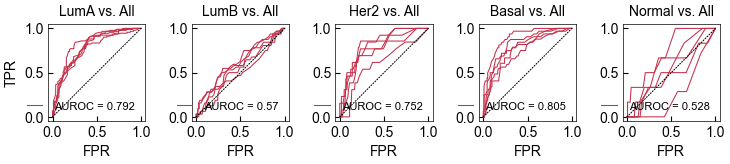

In [14]:
fig, axs = plt.subplot_mosaic(
    """
    abcde
    """,
    figsize=(7.5,3)
)

axes = [axs["a"], axs["b"], axs["c"], axs["d"], axs["e"]]


for ci, csub in enumerate(cancer_subtypes):
    results = subtype_results[csub]
    ax = axes[ci]
    
    # plot each dataset
    aurocs = [resi["auc"] for resi in results]
    for ri, resi in enumerate(results):
        if ri==0:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[0], 
                    label=f"AUROC = {np.round(np.mean(aurocs), 3)}")
        else:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[0])

    ax.plot([0,1], [0,1], ls=":", color="k")
    ax.set_xlabel("FPR")
    
    ax.legend(fontsize=8, loc=4)
    ax.set_aspect("equal")
    ax.set_title(f"{csub} vs. All")
    ax.set_xticks([0,0.5,1])

axes[0].set_ylabel("TPR")
plt.tight_layout()
# plt.savefig("figures/result-7-brca-subtype/cancer.svg")

### Classification from fibroblast nuclear morphology

We can try doing iterative one-vs-all classification of the molecular subtypes of BRCA.

In [15]:
cell_nuhifs = brca_fibroblast_nuhifs.copy()
data = cell_nuhifs.loc[list(labels.index)].copy()
all_data = data.values

In [16]:
subtype_results = {}
for csub in cancer_subtypes:
    binary_labels = all_labels==csub
    
    results = []
    stack_results = []
    stack_labels = []
    for i, (train, test) in enumerate(cv.split(all_data, binary_labels)):
        # generate split
        train_data = all_data[train]
        test_data = all_data[test]
        train_labels = binary_labels[train]
        test_labels = binary_labels[test]

        # classifier
        clf = RandomForestClassifier(random_state=0)
        clf.fit(train_data, train_labels)

        y_pred_proba = clf.predict_proba(test_data)[:,1]
        y_pred = clf.predict(test_data)
        split_results = {
            "bacc": metrics.balanced_accuracy_score(test_labels, y_pred),
            "spearmanr": stats.spearmanr(y_pred, test_labels),
            "feats": list(data.columns)
        }

        # if binary classification we have more info
        if classification_is_binary:
            # aurocs
            fpr, tpr, thr = metrics.roc_curve(test_labels, y_pred_proba)
            score = metrics.roc_auc_score(test_labels, y_pred_proba)
            split_results["auc"] = score
            split_results["fpr"] = fpr
            split_results["tpr"] = tpr
            split_results["thr"] = thr
        results.append(split_results)
        stack_results += list(y_pred)
        stack_labels += list(test_labels)
        
    subtype_results[csub] = results

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abe

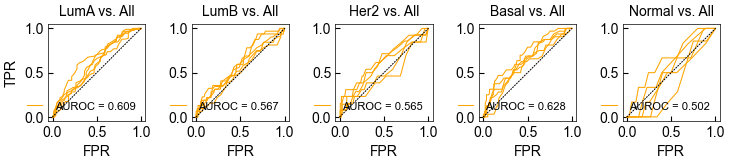

In [17]:
fig, axs = plt.subplot_mosaic(
    """
    abcde
    """,
    figsize=(7.5,3)
)

axes = [axs["a"], axs["b"], axs["c"], axs["d"], axs["e"]]


for ci, csub in enumerate(cancer_subtypes):
    results = subtype_results[csub]
    ax = axes[ci]
    
    # plot each dataset
    aurocs = [resi["auc"] for resi in results]
    for ri, resi in enumerate(results):
        if ri==0:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[1], 
                    label=f"AUROC = {np.round(np.mean(aurocs), 3)}")
        else:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[1])

    ax.plot([0,1], [0,1], ls=":", color="k")
    ax.set_xlabel("FPR")
    
    ax.legend(fontsize=8, loc=4)
    ax.set_aspect("equal")
    ax.set_title(f"{csub} vs. All")
    ax.set_xticks([0,0.5,1])

axes[0].set_ylabel("TPR")
plt.tight_layout()
# plt.savefig("figures/result-7-brca-subtype/fib.svg")

### Classification from lymphocyte nuclear morphology

We can try doing iterative one-vs-all classification of the molecular subtypes of BRCA.

In [18]:
cell_nuhifs = brca_lymphocyte_nuhifs.copy()
data = cell_nuhifs.loc[list(labels.index)].copy()
all_data = data.values

In [19]:
subtype_results = {}
for csub in cancer_subtypes:
    binary_labels = all_labels==csub
    
    results = []
    stack_results = []
    stack_labels = []
    for i, (train, test) in enumerate(cv.split(all_data, binary_labels)):
        # generate split
        train_data = all_data[train]
        test_data = all_data[test]
        train_labels = binary_labels[train]
        test_labels = binary_labels[test]

        # classifier
        clf = RandomForestClassifier(random_state=0)
        clf.fit(train_data, train_labels)

        y_pred_proba = clf.predict_proba(test_data)[:,1]
        y_pred = clf.predict(test_data)
        split_results = {
            "bacc": metrics.balanced_accuracy_score(test_labels, y_pred),
            "spearmanr": stats.spearmanr(y_pred, test_labels),
            "feats": list(data.columns)
        }

        # if binary classification we have more info
        if classification_is_binary:
            # aurocs
            fpr, tpr, thr = metrics.roc_curve(test_labels, y_pred_proba)
            score = metrics.roc_auc_score(test_labels, y_pred_proba)
            split_results["auc"] = score
            split_results["fpr"] = fpr
            split_results["tpr"] = tpr
            split_results["thr"] = thr
        results.append(split_results)
        stack_results += list(y_pred)
        stack_labels += list(test_labels)
        
    subtype_results[csub] = results

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abe

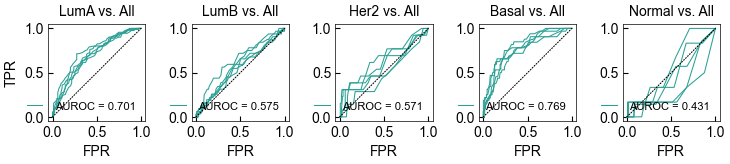

In [20]:
fig, axs = plt.subplot_mosaic(
    """
    abcde
    """,
    figsize=(7.5,3)
)

axes = [axs["a"], axs["b"], axs["c"], axs["d"], axs["e"]]


for ci, csub in enumerate(cancer_subtypes):
    results = subtype_results[csub]
    ax = axes[ci]
    
    # plot each dataset
    aurocs = [resi["auc"] for resi in results]
    for ri, resi in enumerate(results):
        if ri==0:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[2], 
                    label=f"AUROC = {np.round(np.mean(aurocs), 3)}")
        else:
            ax.plot(resi["fpr"], resi["tpr"], color=palette[2])

    ax.plot([0,1], [0,1], ls=":", color="k")
    ax.set_xlabel("FPR")
    ax.set_xticks([0,0.5,1])
    
    ax.legend(fontsize=8, loc=4)
    ax.set_aspect("equal")
    ax.set_title(f"{csub} vs. All")

axes[0].set_ylabel("TPR")
plt.tight_layout()
# plt.savefig("figures/result-7-brca-subtype/lymphocyte.svg")

### Classification from lymphocyte nuclear morphology

We can try doing iterative one-vs-all classification of the molecular subtypes of BRCA.

In [21]:
cell_nuhifs = pd.concat([brca_cancer_nuhifs, brca_fibroblast_nuhifs, brca_lymphocyte_nuhifs], axis=1)
data = cell_nuhifs.loc[list(labels.index)].copy()
all_data = data.values

In [22]:
subtype_results = {}
for csub in cancer_subtypes:
    binary_labels = all_labels==csub
    
    results = []
    stack_results = []
    stack_labels = []
    for i, (train, test) in enumerate(cv.split(all_data, binary_labels)):
        # generate split
        train_data = all_data[train]
        test_data = all_data[test]
        train_labels = binary_labels[train]
        test_labels = binary_labels[test]

        # classifier
        clf = RandomForestClassifier(random_state=0)
        clf.fit(train_data, train_labels)

        y_pred_proba = clf.predict_proba(test_data)[:,1]
        y_pred = clf.predict(test_data)
        split_results = {
            "bacc": metrics.balanced_accuracy_score(test_labels, y_pred),
            "spearmanr": stats.spearmanr(y_pred, test_labels),
            "feats": list(data.columns)
        }

        # if binary classification we have more info
        if classification_is_binary:
            # aurocs
            fpr, tpr, thr = metrics.roc_curve(test_labels, y_pred_proba)
            score = metrics.roc_auc_score(test_labels, y_pred_proba)
            split_results["auc"] = score
            split_results["fpr"] = fpr
            split_results["tpr"] = tpr
            split_results["thr"] = thr
        results.append(split_results)
        stack_results += list(y_pred)
        stack_labels += list(test_labels)
        
    subtype_results[csub] = results

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abel/miniconda3/envs/clin/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/Users/john.abe

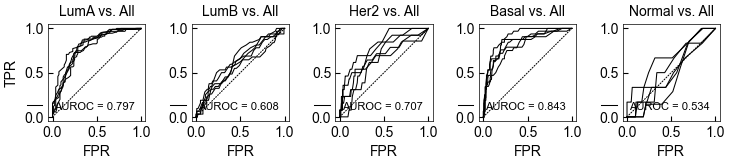

In [23]:
fig, axs = plt.subplot_mosaic(
    """
    abcde
    """,
    figsize=(7.5,3)
)

axes = [axs["a"], axs["b"], axs["c"], axs["d"], axs["e"]]


for ci, csub in enumerate(cancer_subtypes):
    results = subtype_results[csub]
    ax = axes[ci]
    
    # plot each dataset
    aurocs = [resi["auc"] for resi in results]
    for ri, resi in enumerate(results):
        if ri==0:
            ax.plot(resi["fpr"], resi["tpr"], color="k", 
                    label=f"AUROC = {np.round(np.mean(aurocs), 3)}")
        else:
            ax.plot(resi["fpr"], resi["tpr"], color="k")

    ax.plot([0,1], [0,1], ls=":", color="k")
    ax.set_xlabel("FPR")
    ax.set_xticks([0,0.5,1])
    
    ax.legend(fontsize=8, loc=4)
    ax.set_aspect("equal")
    ax.set_title(f"{csub} vs. All")

axes[0].set_ylabel("TPR")
plt.tight_layout()
# plt.savefig("figures/result-7-brca-subtype/combined.svg")